In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json, sys, random
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw 
from matplotlib import pyplot as plt
import keras.callbacks
from keras.utils import np_utils
import pickle
import matplotlib.patches as patches
from skimage.transform import resize

from skimage import color
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

import os
import random

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import json
import time
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()

data = np.array(dataset['data']).astype('uint8')
labels = np.array(dataset['labels']).astype('uint8')

x = data / 255.
x = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])

y = to_categorical(labels, num_classes=2)


model = Sequential()
print(type(model))
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])
    
history = model.fit(x, y, batch_size=64, epochs=30, validation_split=0.2)

<class 'keras.models.Sequential'>
Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 4s 1ms/step - loss: 0.4647 - acc: 0.7944 - val_loss: 0.7513 - val_acc: 0.5975
Epoch 2/30
3200/3200 [==============================] - 2s 567us/step - loss: 0.2065 - acc: 0.9194 - val_loss: 0.3646 - val_acc: 0.8337
Epoch 3/30
3200/3200 [==============================] - 2s 563us/step - loss: 0.1405 - acc: 0.9434 - val_loss: 0.1735 - val_acc: 0.9287
Epoch 4/30
3200/3200 [==============================] - 2s 575us/step - loss: 0.0998 - acc: 0.9619 - val_loss: 0.4140 - val_acc: 0.8137
Epoch 5/30
3200/3200 [==============================] - 2s 586us/step - loss: 0.0811 - acc: 0.9706 - val_loss: 0.6902 - val_acc: 0.7488
Epoch 6/30
3200/3200 [==============================] - 2s 579us/step - loss: 0.0688 - acc: 0.9781 - val_loss: 0.3797 - val_acc: 0.8638
Epoch 7/30
3200/3200 [==============================] - 2s 560us/step - loss: 0.0642 - acc: 0.9784 - val_

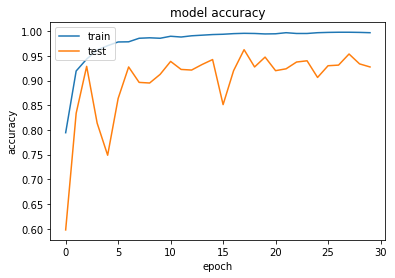

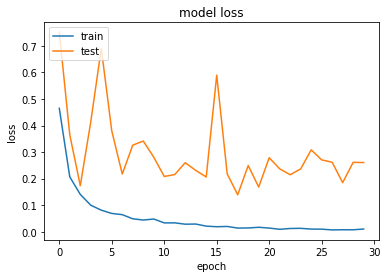

In [3]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
from PIL import Image


def sliding_window(image, stepSize, windowSize,scaler,loaded_model):
    cnt_all = 0
    cnt_ship = 0
    boxes = list()
    scores = list()
    for s in scaler:
        ws = np.array([0,0]);# new window size after rescaling
        ws[0] = int(windowSize[0] * s)
        ws[1] = int(windowSize[1] * s)
        # slide a window across the image
        for x in range(0, image.shape[0]-ws[0], stepSize):
            for y in range(0, image.shape[1]-ws[1], stepSize):
                cnt_all += 1
                snip = image[x:x+ws[0],y:y+ws[1]] #sniping a image in large image to classifiy
                im = resize(snip, (80, 80),anti_aliasing=True)
                im = im.reshape(1,80,80,3)
                # plt.imshow(snip.reshape(80,80,3))
                
                '''
                Code for image Classification, 
                input im, which is 80*80*3
                output c= 0 if not ship, c = 1 if is ship
                '''
                c = loaded_model.predict(im)[0]
                if x % 100 == 0 and y % 100 == 0:
                    print(x, y, c)
                if c[1] > c[0]:
                    cnt_ship += 1
                    boxes.append([x,y,x+80*s,y+80*s])
                    scores.append(c[1])
    print(cnt_all, cnt_ship)
    return boxes, scores

def non_max_suppression(boxes, scores, threshold):
    boxes = np.array(boxes)
    scores = np.array(scores)
    
    # bottom-left origin
    ys1 = boxes[:, 0]
    xs1 = boxes[:, 1]
    # top-right target
    ys2 = boxes[:, 2]
    xs2 = boxes[:, 3]
    boxes = np.append(boxes, ys2.reshape(-1,1), 1)
    boxes = np.append(boxes, xs2.reshape(-1,1), 1)
    # box coordinate ranges are inclusive-inclusive
    areas = (ys2 - ys1) * (xs2 - xs1)
    scores_indexes = scores.argsort().tolist()
    boxes_keep_index = []
    while len(scores_indexes):
        index = scores_indexes.pop()
        boxes_keep_index.append(index)
        if not len(scores_indexes):
            break
        ious = compute_iou(boxes[index], boxes[scores_indexes], areas[index],
                           areas[scores_indexes])
        filtered_indexes = set((ious > threshold).nonzero()[0])
        # if there are no more scores_index
        # then we should pop it
        scores_indexes = [
            v for (i, v) in enumerate(scores_indexes)
            if i not in filtered_indexes
        ]
    ret = [boxes[index] for index in boxes_keep_index]
    return ret


def compute_iou(box, boxes, box_area, boxes_area):
    # this is the iou of the box against all other boxes
    assert boxes.shape[0] == boxes_area.shape[0]
    # get all the origin-ys
    # push up all the lower origin-xs, while keeping the higher origin-xs
    ys1 = np.maximum(box[0], boxes[:, 0])
    # get all the origin-xs
    # push right all the lower origin-xs, while keeping higher origin-xs
    xs1 = np.maximum(box[1], boxes[:, 1])
    # get all the target-ys
    # pull down all the higher target-ys, while keeping lower origin-ys
    ys2 = np.minimum(box[2], boxes[:, 2])
    # get all the target-xs
    # pull left all the higher target-xs, while keeping lower target-xs
    xs2 = np.minimum(box[3], boxes[:, 3])
    # each intersection area is calculated by the
    # pulled target-x minus the pushed origin-x
    # multiplying
    # pulled target-y minus the pushed origin-y
    # we ignore areas where the intersection side would be negative
    # this is done by using maxing the side length by 0
    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)
    # each union is then the box area
    # added to each other box area minusing their intersection calculated above
    unions = box_area + boxes_area - intersections
    # element wise division
    # if the intersection is 0, then their ratio is 0
    ious = intersections / unions
    return ious

/datasets/home/96/896/j4lu/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Shape of hog_image: (80, 80)
Shape of hog_feature: (512,)
Shape of labels: (360, 1)


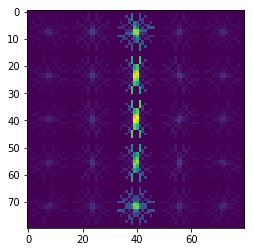

In [5]:
img = Image.open('heading.png') 
# Output Images 
zero_heading_img = img.rotate(96)
# print(zero_heading_img.size) # 150x150
# zero_heading_img.crop((20,20,130,130)).show()

gray_images = list()
labels = list()
for angle in range(0, 360, 1):
    rotated = zero_heading_img.rotate(angle)
    cropped = rotated.crop((20,20,130,130))
    resized = cropped.resize((80,80),Image.ANTIALIAS)
    np_file = np.array(resized)
    gray = color.rgb2gray(np_file) # numpy.ndarray, 80x80
    # plt.imshow(gray)
    gray_images.append(gray)
    labels.append(angle)

ppc = 16
hog_images = []
hog_features = []
for image in gray_images:
    hog_feature, hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(4, 4), block_norm= 'L2',visualise=True)
    hog_images.append(hog_image)
    hog_features.append(hog_feature)

plt.imshow(hog_images[0])

print('Shape of hog_image: {}'.format(hog_images[0].shape)) # 80x80
print('Shape of hog_feature: {}'.format(hog_features[0].shape)) # 512

labels =  np.array(labels).reshape(-1,1)
print('Shape of labels: {}'.format(labels.shape)) # 90x1

In [6]:
heading_regressor = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels))
np.random.shuffle(data_frame)

print('Shape of data_frame: {}'.format(data_frame.shape)) # 90x513

#What percentage of data you want to keep for training
train_ratio = 0.8
partition = int(len(hog_features) * train_ratio)

x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

heading_regressor.fit(x_train,y_train)

Shape of data_frame: (360, 513)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
def predict_heading(image):
    fig = plt.figure(figsize=(8,8))
    axarr = fig.subplots(nrows=3, ncols=1)
    
    
    axarr[0].imshow(image)
    resized = image.resize((80,80),Image.ANTIALIAS)
    np_file = np.array(resized)
    gray = color.rgb2gray(np_file) # numpy.ndarray, 80x80
    axarr[1].imshow(gray)
    hog_feature, hog_image = hog(gray, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(4, 4), block_norm= 'L2',visualise=True)
    axarr[2].imshow(hog_image)
    hog_feature = np.expand_dims(hog_feature, axis=0)
    return int(heading_regressor.predict(hog_feature))

In [8]:
def get_heading_for_boxes(image, boxes):
    headings = list()
    for box in boxes:
        y1 = int(box[0])
        x1 = int(box[1])
        y2 = int(box[2])
        x2 = int(box[3])
    
        box_image = image[y1:y2,x1:x2,:]
        box_image = resize(box_image, (80, 80),anti_aliasing=True)
        print(box_image.shape)
        gray = color.rgb2gray(box_image) # numpy.ndarray, 80x80
        hog_feature, hog_image = hog(gray, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(4, 4), block_norm= 'L2',visualise=True)
        hog_feature = np.expand_dims(hog_feature, axis=0)
        heading = heading_regressor.predict(hog_feature)
        headings.append(heading)
    return headings

In [9]:
def show_ship(image, boxes, headings=[]):
    fig,ax = plt.subplots(1)
    fig.set_size_inches(15,12)
    ax.imshow(image)
    i = 0
    for box in boxes:
        y_of_top_left = box[0]
        x_of_top_left = box[1]
        width = box[3] - box[1]
        height = box[2] - box[0]
        
        rect = patches.Rectangle((x_of_top_left,y_of_top_left),width,height,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
        if len(headings) != 0:
            heading = int(headings[i])
            if heading > 180:
                heading -= 180

            plt.text(x_of_top_left, y_of_top_left-10, heading,fontsize=20, color='white')
        i += 1
    plt.show()

(582, 1028, 3)


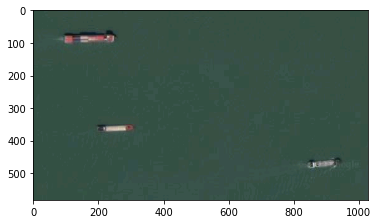

In [10]:
import cv2

image = plt.imread('test.png')

if len(image.shape) > 2 and image.shape[2] == 4:
    #convert the image from RGBA2RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    
print(image.shape)
plt.imshow(image)

In [11]:
boxes, scores = sliding_window(image, 25, (80,80),[1,2],model)
print(boxes)
# sliding_window(image, stepSize, windowSize,scaler,loaded_model)

0 0 [9.9981743e-01 1.8258669e-04]
0 100 [9.9991584e-01 8.4119958e-05]
0 200 [9.9991405e-01 8.5892781e-05]
0 300 [9.9981493e-01 1.8510957e-04]
0 400 [9.9982256e-01 1.7747468e-04]
0 500 [9.9982941e-01 1.7051454e-04]
0 600 [9.9981529e-01 1.8472836e-04]
0 700 [9.9981457e-01 1.8543990e-04]
0 800 [9.9981171e-01 1.8835388e-04]
0 900 [9.9980968e-01 1.9039137e-04]
100 0 [9.9983633e-01 1.6369493e-04]
100 100 [9.9994338e-01 5.6629495e-05]
100 200 [9.9989474e-01 1.0530639e-04]
100 300 [9.9982196e-01 1.7805300e-04]
100 400 [9.9981588e-01 1.8419194e-04]
100 500 [9.9982136e-01 1.7868602e-04]
100 600 [9.9981529e-01 1.8477469e-04]
100 700 [9.9981827e-01 1.8181502e-04]
100 800 [9.9981850e-01 1.8150701e-04]
100 900 [9.9982101e-01 1.7899332e-04]
200 0 [9.997986e-01 2.014172e-04]
200 100 [9.9979287e-01 2.0715299e-04]
200 200 [9.9980062e-01 1.9944864e-04]
200 300 [9.9982733e-01 1.7270753e-04]
200 400 [9.9981254e-01 1.8743445e-04]
200 500 [9.9980742e-01 1.9255622e-04]
200 600 [9.9982208e-01 1.7791045e-04]
20

(80, 80, 3)
(80, 80, 3)


/datasets/home/96/896/j4lu/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/datasets/home/96/896/j4lu/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


(80, 80, 3)
(80, 80, 3)


/datasets/home/96/896/j4lu/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/datasets/home/96/896/j4lu/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[array([273.]), array([84.]), array([273.]), array([277.])]


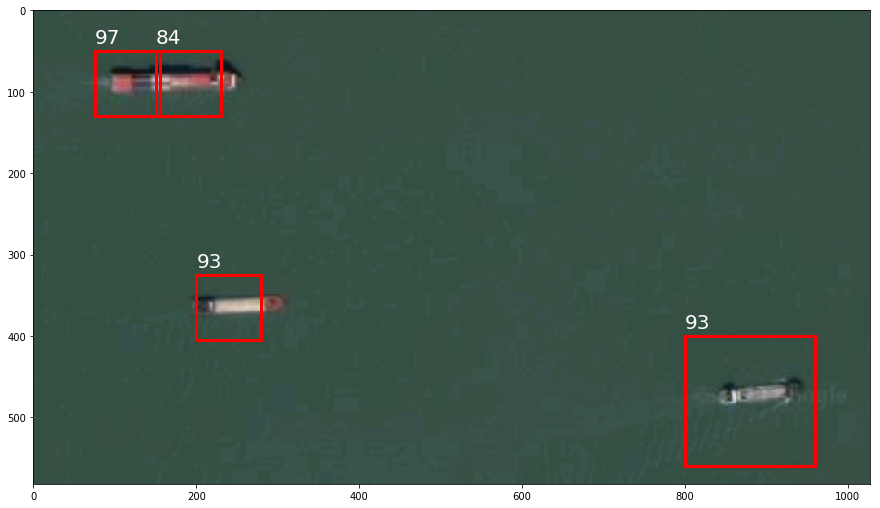

In [13]:
boxes_after_nms = non_max_suppression(boxes, scores, 0.1)
headings = get_heading_for_boxes(image, boxes_after_nms)
print(headings)
show_ship(image, boxes_after_nms, headings)

# show_ship(image, boxes, [])
# boxes_after_nms = non_max_suppression(boxes, scores, 0.1)
# show_ship(image, boxes_after_nms, [])